In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

# Pre-processing of the data

##### The dataset contains entries such as BiSb(Se0.92Br0.08)3. They need to be expanded to look like Bi1.0Sb1.0Se2.76Br0.24 so they can be featurised.

In [ ]:
#this is the code used for that task, generated with ChatGPT-4. The prompts that were used are below:

#Prompt 1: take a look at this dataset and tell me when you're done

#Prompt 2: The column named "Formula" is written quite convoluted. I want to rewrite it so that the brackets are gone.
#To do that, I need to multiply the coefficients. Do you understand? Answer yes or no

#Prompt 3: Ok, I will give you an example. The first entry in Formula is BiSb(Se0.92Br0.08)3.
#To remove the brackets, I will have to multiply. This will be the end result: Bi1Sb1Se2.76Br0.24.
#Do you see the logic? Bi and Sb had not coefficients, so I assigned 1. Se had 0.92, so I multiplied by 3 so the final result is 2.76. 
#Same for Br, it had 0.08 and when multiply by 3, it results in Br0.24.
#The final result is Bi1Sb1Se2.76Br0.24. Do you see the process? answer yes or no.

# Adjusted function to handle cases with coefficients applied to bracketed groups
def expand_formula_with_outer_coefficient(formula):
    element_pattern = r"([A-Z][a-z]*)(\d*\.?\d*)|\(([A-Za-z0-9.]+)\)(\d*\.?\d*)"
    expanded_formula = ""
    
    matches = re.finditer(element_pattern, formula)
    
    for match in matches:
        element, coefficient, group, multiplier = match.groups()
        
        if group:  # If there's a bracketed group
            multiplier = float(multiplier) if multiplier else 1.0
            # Process each element within the brackets
            inner_elements = re.findall(r"([A-Z][a-z]*)(\d*\.?\d*)", group)
            for inner_element, inner_coefficient in inner_elements:
                inner_coefficient = float(inner_coefficient) if inner_coefficient else 1.0
                expanded_formula += f"{inner_element}{round(inner_coefficient * multiplier, 6)}"
        else:  # Process elements outside brackets
            coefficient = float(coefficient) if coefficient else 1.0
            expanded_formula += f"{element}{round(coefficient, 6)}"

    return expanded_formula

# Apply the adjusted function to the 'Formula' column
data['Expanded_Formula'] = data['Formula'].apply(expand_formula_with_outer_coefficient)

In [2]:
df = pd.read_csv("estm_expanded.csv")
df

,Formula,temperature(K),seebeck_coefficient(μV/K),electrical_conductivity(S/m),thermal_conductivity(W/mK),power_factor(W/mK2),ZT,reference
0,Bi1.0Sb1.0Se2.76Br0.24,300.0,-110.00,27766.0,0.6300,0.000336,0.159985,10.1002/adfm.201806558
1,Bi1.0Sb1.0Se2.76Br0.24,400.0,-138.00,23883.0,0.5700,0.000455,0.319177,10.1002/adfm.201806558
2,Bi1.0Sb1.0Se2.76Br0.24,500.0,-163.00,20850.0,0.5300,0.000554,0.522607,10.1002/adfm.201806558
3,Bi1.0Sb1.0Se2.76Br0.24,600.0,-181.00,19000.0,0.5100,0.000622,0.732305,10.1002/adfm.201806558
4,Bi1.0Sb1.0Se2.76Br0.24,700.0,-193.00,17925.0,0.5000,0.000668,0.940000,10.1002/adfm.201806558
...,...,...,...,...,...,...,...,...
5200,Ge9.0Sb2.0Te12.0,423.0,77.28,173636.0,2.8586,0.001037,0.153448,https://doi.org/10.1021/acsami.0c02155
5201,Ge9.0Sb2.0Te12.0,525.0,97.50,136364.0,2.7576,0.001296,0.246795,https://doi.org/10.1021/acsami.0c02155
5202,Ge9.0Sb2.0Te12.0,625.0,112.88,120000.0,2.8232,0.001529,0.338496,https://doi.org/10.1021/acsami.0c02155
5203,Ge9.0Sb2.0Te12.0,725.0,135.19,108182.0,2.5354,0.001977,0.565374,https://doi.org/10.1021/acsami.0c02155


In [ ]:
#documentation available at https://hackingmaterials.lbl.gov/matminer/matminer.featurizers.composition.html#id15

from matminer.featurizers.conversions import StrToComposition
df = StrToComposition().featurize_dataframe(df, "Formula")
df.head()

In [ ]:
from matminer.featurizers.composition import ElementProperty

ep_feat = ElementProperty.from_preset(preset_name="magpie")
df = ep_feat.featurize_dataframe(df, col_id="composition")
df

In [ ]:
df.to_csv("estm_feat.csv")

# ML 

In [3]:
# load the data
df = pd.read_csv("estm_feat.csv")
df 

,Formula,temperature(K),seebeck_coefficient(μV/K),electrical_conductivity(S/m),thermal_conductivity(W/mK),power_factor(W/mK2),ZT,reference,composition,MagpieData minimum Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Bi1.0Sb1.0Se2.76Br0.24,300.0,-110.00,27766.0,0.6300,0.000336,0.159985,10.1002/adfm.201806558,Bi1 Sb1 Se2.76 Br0.24,34,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
1,Bi1.0Sb1.0Se2.76Br0.24,400.0,-138.00,23883.0,0.5700,0.000455,0.319177,10.1002/adfm.201806558,Bi1 Sb1 Se2.76 Br0.24,34,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
2,Bi1.0Sb1.0Se2.76Br0.24,500.0,-163.00,20850.0,0.5300,0.000554,0.522607,10.1002/adfm.201806558,Bi1 Sb1 Se2.76 Br0.24,34,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
3,Bi1.0Sb1.0Se2.76Br0.24,600.0,-181.00,19000.0,0.5100,0.000622,0.732305,10.1002/adfm.201806558,Bi1 Sb1 Se2.76 Br0.24,34,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
4,Bi1.0Sb1.0Se2.76Br0.24,700.0,-193.00,17925.0,0.5000,0.000668,0.940000,10.1002/adfm.201806558,Bi1 Sb1 Se2.76 Br0.24,34,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,Ge9.0Sb2.0Te12.0,423.0,77.28,173636.0,2.8586,0.001037,0.153448,https://doi.org/10.1021/acsami.0c02155,Ge9 Sb2 Te12,32,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152
5201,Ge9.0Sb2.0Te12.0,525.0,97.50,136364.0,2.7576,0.001296,0.246795,https://doi.org/10.1021/acsami.0c02155,Ge9 Sb2 Te12,32,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152
5202,Ge9.0Sb2.0Te12.0,625.0,112.88,120000.0,2.8232,0.001529,0.338496,https://doi.org/10.1021/acsami.0c02155,Ge9 Sb2 Te12,32,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152
5203,Ge9.0Sb2.0Te12.0,725.0,135.19,108182.0,2.5354,0.001977,0.565374,https://doi.org/10.1021/acsami.0c02155,Ge9 Sb2 Te12,32,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152


In [5]:
# Define an objective function for Optuna hyperparameter tuning
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 100)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

In [6]:
# Separate features and target
target = 'ZT'
features = df.drop(columns=['ZT', 'reference', 'composition', 'Formula', 'seebeck_coefficient(μV/K)', 'electrical_conductivity(S/m)',
                            'thermal_conductivity(W/mK)', 'power_factor(W/mK2)'])
X = features
y = df[target]

In [7]:
features

,temperature(K),MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,300.0,34,83,49,47.248000,15.801600,34,85,95,10,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
1,400.0,34,83,49,47.248000,15.801600,34,85,95,10,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
2,500.0,34,83,49,47.248000,15.801600,34,85,95,10,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
3,600.0,34,83,49,47.248000,15.801600,34,85,95,10,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
4,700.0,34,83,49,47.248000,15.801600,34,85,95,10,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,423.0,32,52,20,44.086957,9.459357,52,79,90,11,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152
5201,525.0,32,52,20,44.086957,9.459357,52,79,90,11,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152
5202,625.0,32,52,20,44.086957,9.459357,52,79,90,11,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152
5203,725.0,32,52,20,44.086957,9.459357,52,79,90,11,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152


In [9]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# Define the search space for BayesSearchCV
param_space = {
    'n_estimators': (50, 500),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'max_depth': (3, 10),
    'min_samples_split': (5, 10, 15),
    'min_samples_leaf': (1, 5, 10),
    'subsample': (0.25, 0.5, 'uniform')
}

In [27]:
# Initialize and run BayesSearchCV
model = GradientBoostingRegressor(random_state=42)
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=32,  # Number of parameter settings that are sampled
    n_jobs=-1
)
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
              n_iter=32, n_jobs=-1, scoring='neg_mean_absolute_error',
              search_spaces={'learning_rate': (0.01, 0.1, 'log-uniform'),
                             'max_depth': (3, 10), 'min_samples_leaf': (1, 5),
                             'min_samples_split': (2, 10),
                             'n_estimators': (50, 300),
                             'subsample': (0.5, 1.0, 'uniform')})

In [30]:
# Retrieve the best parameters from BayesSearchCV
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: OrderedDict({'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.5})


In [31]:
model = GradientBoostingRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=9, n_estimators=300, random_state=42,
                          subsample=0.5)

In [32]:
# Initialize lists to store training and test metrics
train_mae, test_mae = [], []
train_r2, test_r2 = [], []

In [33]:
# Track performance at each stage using staged_predict
for y_train_pred, y_test_pred in zip(model.staged_predict(X_train), model.staged_predict(X_test)):
    # Calculate MAE and R^2 for both train and test sets
    train_mae.append(mean_absolute_error(y_train, y_train_pred))
    test_mae.append(mean_absolute_error(y_test, y_test_pred))
    train_r2.append(r2_score(y_train, y_train_pred))
    test_r2.append(r2_score(y_test, y_test_pred))

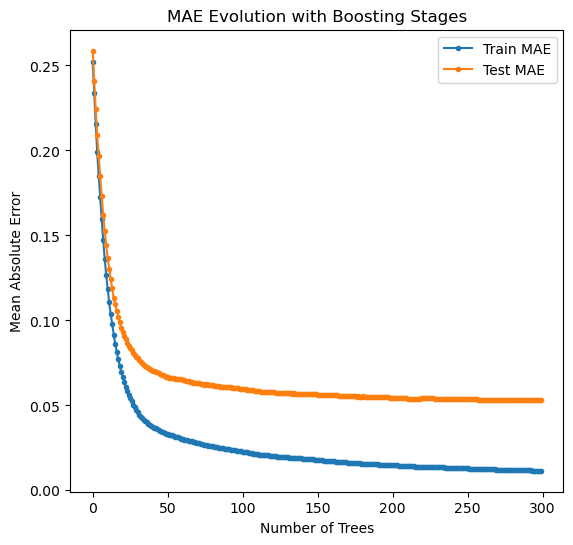

In [42]:
# Plot the learning curve for MAE
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_mae, label="Train MAE", marker='.')
plt.plot(test_mae, label="Test MAE", marker='.')
plt.xlabel("Number of Trees")
plt.ylabel("Mean Absolute Error")
plt.title("MAE Evolution with Boosting Stages")
plt.legend()

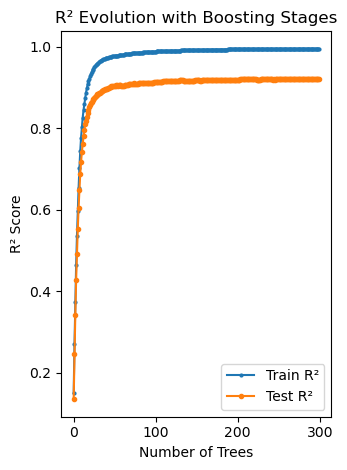

In [41]:
# Plot the learning curve for R²
plt.subplot(1, 2, 2)
plt.plot(train_r2, label="Train R²", marker='.', markersize=4)
plt.plot(test_r2, label="Test R²", marker='.')
plt.xlabel("Number of Trees")
plt.ylabel("R² Score")
plt.title("R² Evolution with Boosting Stages")
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
# Define your chosen hyperparameters here
chosen_params = {
    'n_estimators': 150,
    'learning_rate': 0.1,
    'max_depth': 20,
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    'subsample': 0.8
}

# Train the model with the specified parameters
model = GradientBoostingRegressor(**chosen_params)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                          n_estimators=150, subsample=0.8)

In [48]:
# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_test_pred)
#mse = mean_squared_error(y_test, y_test_pred)
#rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

# Print out the evaluation metrics
print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
#print(f"Mean Squared Error (MSE): {mse:.3f}")
#print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.059
R² Score: 0.912
